In [1]:
import segmentation_models as sm
import tensorflow as tf
tf.config.run_functions_eagerly(True)
from fetch_data import fetch
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
from UNet import build_unet
from visualise import visualize, denormalize

2023-02-15 21:02:05.474955: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-15 21:02:05.570338: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-15 21:02:05.573128: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-15 21:02:05.573141: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudar

Segmentation Models: using `tf.keras` framework.


In [2]:
base_dir = '/media/dev/WinD/Curious Dev B/PROJECT STAGE - II/ISIC 2017 for segmentation (python) (copy)/'
batch_size = 16
input_size = (224, 224)
num_epochs = 20
grp = 0
metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

callbacks = [ModelCheckpoint('./best_model.h5', 
                             monitor = "val_f1-score",
                             save_weights_only=True, 
                             save_best_only=True, 
                             mode='min',
                             initial_value_threshold = 0.5283),
            ReduceLROnPlateau(monitor = "val_f1-score",
                             factor = 0.2,
                             patience = 4)]

In [3]:
train_dataset, validation_dataset = fetch(base_dir, input_size, grp)

train_dataset = train_dataset.batch(batch_size)
# train_dataset = train_dataset.shuffle(buffer_size=128)

validation_dataset = validation_dataset.batch(1)

2023-02-15 21:02:07.154047: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-02-15 21:02:07.154069: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-15 21:02:07.154082: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Turbo): /proc/driver/nvidia/version does not exist
2023-02-15 21:02:07.154329: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/dev/anaconda3/lib/python3.9/site-packages/tensorflow/python/dat

In [4]:
model = sm.Unet(backbone_name = "resnet34",
                   input_shape=(224, 224, 3))

model.compile(optimizer=Adam(learning_rate = 0.0001), 
              loss=sm.losses.bce_jaccard_loss, 
              metrics=metrics)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 bn_data (BatchNormalization)   (None, 224, 224, 3)  9           ['data[0][0]']                   
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['bn_data[0][0]']                
                                                                                                  
 conv0 (Conv2D)                 (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']   

 D)                                                                                               
                                                                                                  
 stage1_unit3_conv1 (Conv2D)    (None, 56, 56, 64)   36864       ['zero_padding2d_6[0][0]']       
                                                                                                  
 stage1_unit3_bn2 (BatchNormali  (None, 56, 56, 64)  256         ['stage1_unit3_conv1[0][0]']     
 zation)                                                                                          
                                                                                                  
 stage1_unit3_relu2 (Activation  (None, 56, 56, 64)  0           ['stage1_unit3_bn2[0][0]']       
 )                                                                                                
                                                                                                  
 zero_padd

                                                                                                  
 stage2_unit3_relu2 (Activation  (None, 28, 28, 128)  0          ['stage2_unit3_bn2[0][0]']       
 )                                                                                                
                                                                                                  
 zero_padding2d_13 (ZeroPadding  (None, 30, 30, 128)  0          ['stage2_unit3_relu2[0][0]']     
 2D)                                                                                              
                                                                                                  
 stage2_unit3_conv2 (Conv2D)    (None, 28, 28, 128)  147456      ['zero_padding2d_13[0][0]']      
                                                                                                  
 add_5 (Add)                    (None, 28, 28, 128)  0           ['stage2_unit3_conv2[0][0]',     
          

                                                                                                  
 stage3_unit2_conv2 (Conv2D)    (None, 14, 14, 256)  589824      ['zero_padding2d_19[0][0]']      
                                                                                                  
 add_8 (Add)                    (None, 14, 14, 256)  0           ['stage3_unit2_conv2[0][0]',     
                                                                  'add_7[0][0]']                  
                                                                                                  
 stage3_unit3_bn1 (BatchNormali  (None, 14, 14, 256)  1024       ['add_8[0][0]']                  
 zation)                                                                                          
                                                                                                  
 stage3_unit3_relu1 (Activation  (None, 14, 14, 256)  0          ['stage3_unit3_bn1[0][0]']       
 )        

                                                                                                  
 stage3_unit6_relu1 (Activation  (None, 14, 14, 256)  0          ['stage3_unit6_bn1[0][0]']       
 )                                                                                                
                                                                                                  
 zero_padding2d_26 (ZeroPadding  (None, 16, 16, 256)  0          ['stage3_unit6_relu1[0][0]']     
 2D)                                                                                              
                                                                                                  
 stage3_unit6_conv1 (Conv2D)    (None, 14, 14, 256)  589824      ['zero_padding2d_26[0][0]']      
                                                                                                  
 stage3_unit6_bn2 (BatchNormali  (None, 14, 14, 256)  1024       ['stage3_unit6_conv1[0][0]']     
 zation)  

                                                                                                  
 stage4_unit3_conv1 (Conv2D)    (None, 7, 7, 512)    2359296     ['zero_padding2d_32[0][0]']      
                                                                                                  
 stage4_unit3_bn2 (BatchNormali  (None, 7, 7, 512)   2048        ['stage4_unit3_conv1[0][0]']     
 zation)                                                                                          
                                                                                                  
 stage4_unit3_relu2 (Activation  (None, 7, 7, 512)   0           ['stage4_unit3_bn2[0][0]']       
 )                                                                                                
                                                                                                  
 zero_padding2d_33 (ZeroPadding  (None, 9, 9, 512)   0           ['stage4_unit3_relu2[0][0]']     
 2D)      

                                                                                                  
 decoder_stage2b_bn (BatchNorma  (None, 56, 56, 64)  256         ['decoder_stage2b_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 decoder_stage2b_relu (Activati  (None, 56, 56, 64)  0           ['decoder_stage2b_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 decoder_stage3_upsampling (UpS  (None, 112, 112, 64  0          ['decoder_stage2b_relu[0][0]']   
 ampling2D)                     )                                                                 
                                                                                                  
 decoder_s

In [5]:
history = model.fit(train_dataset, epochs=num_epochs,
                    validation_data=validation_dataset,
                    callbacks=callbacks)

Epoch 1/20
163/163 [==============================] - 923s 6s/step - loss: 1.1961 - iou_score: 0.3688 - f1-score: 0.5298 - val_loss: 1.2226 - val_iou_score: 0.3493 - val_f1-score: 0.4937 - lr: 1.0000e-04
Epoch 2/20
163/163 [==============================] - 925s 6s/step - loss: 0.9850 - iou_score: 0.4692 - f1-score: 0.6276 - val_loss: 1.1555 - val_iou_score: 0.3926 - val_f1-score: 0.5283 - lr: 1.0000e-04
Epoch 3/20
163/163 [==============================] - 913s 6s/step - loss: 0.8869 - iou_score: 0.5182 - f1-score: 0.6704 - val_loss: 1.4449 - val_iou_score: 0.1868 - val_f1-score: 0.2973 - lr: 1.0000e-04
Epoch 4/20
163/163 [==============================] - 980s 6s/step - loss: 0.8383 - iou_score: 0.5385 - f1-score: 0.6890 - val_loss: 1.2552 - val_iou_score: 0.3362 - val_f1-score: 0.4783 - lr: 1.0000e-04
Epoch 5/20
163/163 [==============================] - 927s 6s/step - loss: 0.7517 - iou_score: 0.5880 - f1-score: 0.7292 - val_loss: 1.2977 - val_iou_score: 0.3010 - val_f1-score: 0.43

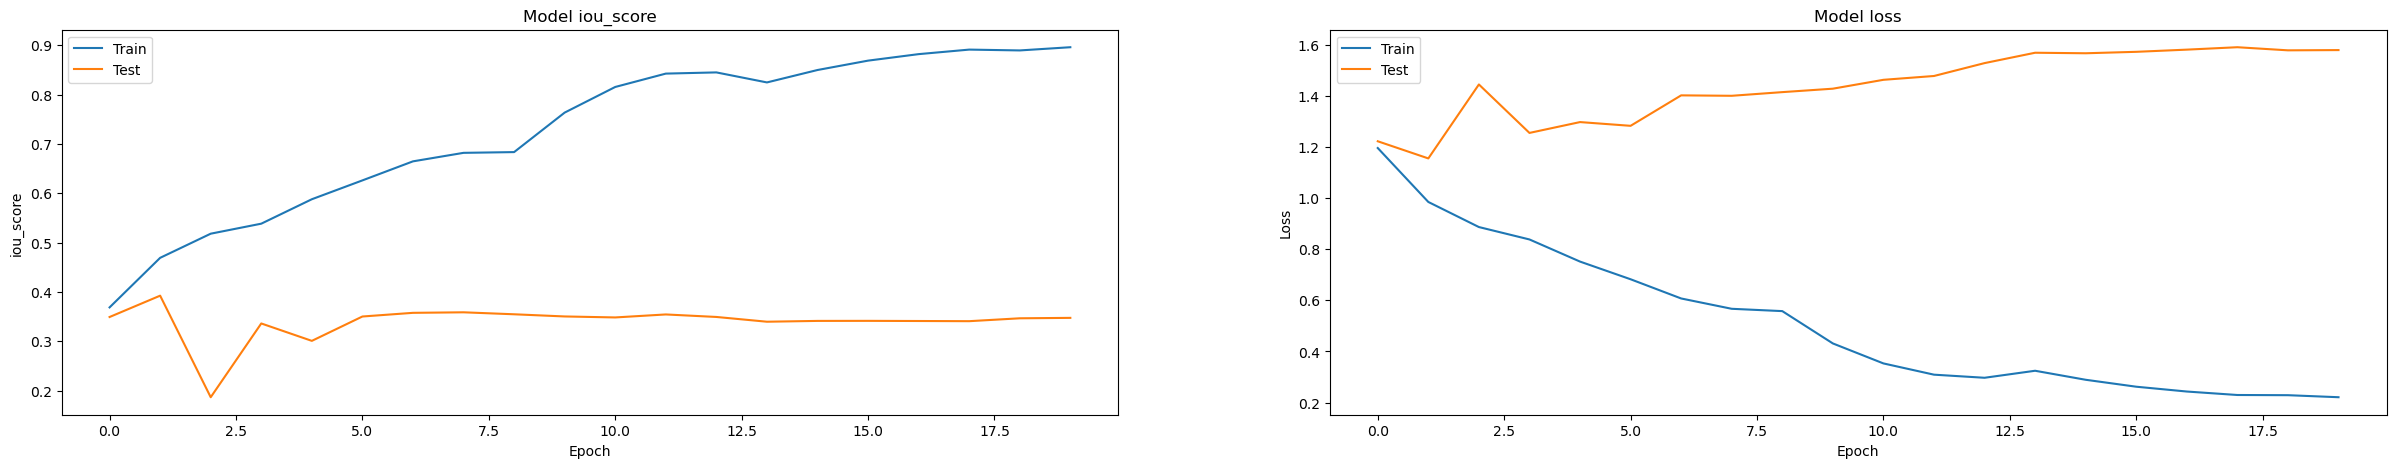

In [7]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [6]:
model.load_weights('best_model.h5') 

ValueError: Layer count mismatch when loading weights from file. Model expected 93 layers, found 262 saved layers.

In [ ]:
scores = model.evaluate(validation_dataset)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

In [ ]:
print(tf.data.experimental.cardinality(validation_dataset))
for (img, mask) in validation_dataset:
    print(img.shape)
    print(mask.shape)

In [ ]:
for batch in validation_dataset:
    image, gt_mask = batch
    image = image.numpy()
    gt_mask = gt_mask.numpy()
    pr_mask = model.predict(image).round()
    
    visualize(
        image=denormalize(image.squeeze()),
        gt_mask=gt_mask[..., 0].squeeze(),
        pr_mask=pr_mask[..., 0].squeeze(),
    )

In [ ]:
# Try changing loss to sm.losses.bce_jaccard_loss
# Try changing backbone to resnet34 and resnet50
# Try dividing the data into different classes and segment each class separately
# Change batch_size and change learning_rate to 1e-05
# highest yet recorded was 58 with bce_jaccard loss - resnet34 - batch 16 - lr 1e-4 - grp=M
# Training metrics are fair enough, validation is bad: try extracting validation from training itself or copy validation into train
# Try: 
'''dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)'''